# Graph Lab

## Header information:

  - Author #1: Nathan Luong (luongn4@mcmaster.ca)
  - Author #2: William Pai (paiw@mcmaster.ca)
  - Gitlab URL: https://gitlab.cas.mcmaster.ca/luongn4/l1-graph-lab.git
  - Avenue to Learn group name: Graph 01

## Week 1

### Importing Packages

In [1]:
from GraphModels import Node, DirectedEdge, EdgeWeightedDigraph
from GraphParser import GraphParser
from MetricExtractor import GraphMetricExtractor
import matplotlib.pyplot as plt
from shortest_paths.factory import ShortestPathFactory


### Parsing Data

In [2]:
parser = GraphParser()
graph = parser.parseGraph("./_dataset/london.stations.csv", "./_dataset/london.connections.csv")
mapping = graph.getMapping()
nodeData = graph.getNodeData()

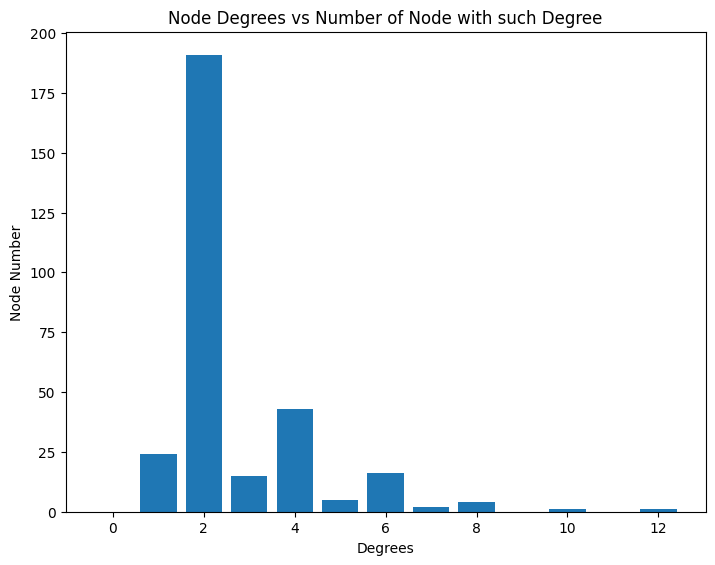

In [3]:
metricExtractor = GraphMetricExtractor(graph)

numOfNodes = metricExtractor.getNodeNum()
numOfEdges = metricExtractor.getEdgeNum()
averageDegree = metricExtractor.getNodeAverageDegree()

# print(f"Graph has {numOfNodes} nodes, {numOfEdges} edges with an average degree of {averageDegree}")

degreeDistribution = metricExtractor.getNodeDegreeDistribution()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
degree = degreeDistribution.keys()
nodeNum = degreeDistribution.values()
ax.set_title('Node Degrees vs Number of Node with such Degree')
ax.bar(degree,nodeNum)
plt.xlabel("Degrees")
plt.ylabel("Node Number")
plt.show()

## Shortest Path Algorithms and Benchmarking

**How to rank paths of the same length?**

If multiple paths are discovered to be of the same length (in this case, distance fromstart to end), we rank them by the least number of line changes, as it requires the traveller to switch subways the least often. This is achieved by modifying the relax function to also keep track of the number of line changes. If the new path has the same distance as the old path, we compare the number of line changes. If the new path has less line changes, we update the path.

**What are the right KPIs to measure?**

The following code showcases the KPIs for the two shortest path algorithms. The KPI is a measure of the number of times the algorithm has to update the distance of a vertex. The lower the number of edges relaxed, the better the algorithm is.

**What are the right cases (itineraries) to consider for this benchmark?**

The best benchmark results are achieved when the itineraries have a starting and destination station that has more than one path to travel between them. For even better results, multiple paths that have the same length (total travel time) forces the algorithms to compute the total number of line changes. For the purposes for this lab, we will be randomly generating starting and ending stations. The benchmark will be run multiple times for each algorithm, and the average number of edges relaxed will be calculated.

In [4]:
import random
random.seed(1659644754)

In [5]:
dataset = {
    "1": {"start": random.randrange(1, 300), "end": random.randrange(1, 300)},
    "2": {"start": random.randrange(1, 300), "end": random.randrange(1, 300)},
    "3": {"start": random.randrange(1, 300), "end": random.randrange(1, 300)},
}

In [6]:
from shortest_paths.interface import ShortestPathStrategy
from Itinerary import Itinerary

def multi_shortest_path(algo: ShortestPathStrategy, dataset: dict) -> dict:
    result = {}
    for k in dataset.keys():
        itinerary = Itinerary(algo, dataset[k]["start"], dataset[k]["end"])
        result[k] = itinerary.returnPath(graph, mapping, nodeData)["ops"]
    return result

### A Star Algorithm

In [7]:
algo = ShortestPathFactory.build("A_Star")
a_star_results = multi_shortest_path(algo, dataset)
a_star_results

{'1': 17, '2': 28, '3': 41}

In [8]:
algo = ShortestPathFactory.build("A_Star")
a_star_rdesults = multi_shortest_path(algo, dataset)
a_star_results

{'1': 17, '2': 28, '3': 41}

### Pattern Choice and Justification

To easily manage, integrate and control different ways to solve the shortest path problem on the graphs, our team decided to use the strategy pattern to implement the shortest path strategies.

<div style="width:auto; height:auto; display:flex; justify-content:center; align-items:center">
    <img src="assets/FactoryUML.png" alt="UML Diagram for Shortest Path Strategies" width="600"/>
</div>

#### Justification
- Strategy pattern allows different shortest path algorithms to be added independently from the context. Strategies can exist on their own file which seperate the concern from the Itinerary class. 
- Factory Pattern abstractn the user away from strategy creation by initializing the strategy within the build function.
- Users can choose whatever strategies they want on the same grah object without needing to understand how the algorithms are implemented. 
- Strategies development are isolated and controlled (recieve the same input and return the same output) which makes developing them easy and less prone to human error.
  
#### Benchmark result analysis

#### Work
Willie:
- Benchmarking
- Dijkstra Implementation
- Testing

Nathan: 
- Factory Pattern Implementation 
- A Star Implementation
- Report + UML


### Benchmarking Execution Time

In [9]:
from os.path import exists
if not exists('outputs/pyperf_measurements.json'):
    !{'pipenv run python benchmark.py -o outputs/pyperf_measurements.json'}
!{'pipenv run python -m pyperf hist outputs/pyperf_measurements.json'}

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
DijkstraAlgo

1.17 ms: 1 ########
1.20 ms: 1 ########
1.22 ms: 2 ###############
1.25 ms: 5 ######################################
1.27 ms: 5 ######################################
1.30 ms: 9 ####################################################################
1.33 ms: 6 #############################################
1.35 ms: 5 ######################################
1.38 ms: 1 ########
1.41 ms: 3 #######################
1.43 ms: 3 #######################
1.46 ms: 5 ######################################
1.49 ms: 1 ########
1.51 ms: 4 ##############################
1.54 ms: 1 ########
1.57 ms: 1 ########
1.59 ms: 3 #######################
1.62 ms: 1 ########

In [10]:
from pyperf import BenchmarkSuite

def load_bench_measurements(name: str, json_filename: str) -> list[float]:
    """extract the values for a given benchmark"""
    suite = BenchmarkSuite.load(json_filename)
    bench = suite.get_benchmark(name)
    return list(bench.get_values())

In [11]:
dijkstra_vals = load_bench_measurements('DijkstraAlgo', 'outputs/pyperf_measurements.json')
a_star_vals = load_bench_measurements('A_Star', 'outputs/pyperf_measurements.json')

In [12]:
def draw_hist(values: list[float], title: str, canvas):
    canvas.set_title(title)
    canvas.set(xlabel='exec time (s)', ylabel='|instances|')
    canvas.hist(values, 20) # putting values into 10 beans

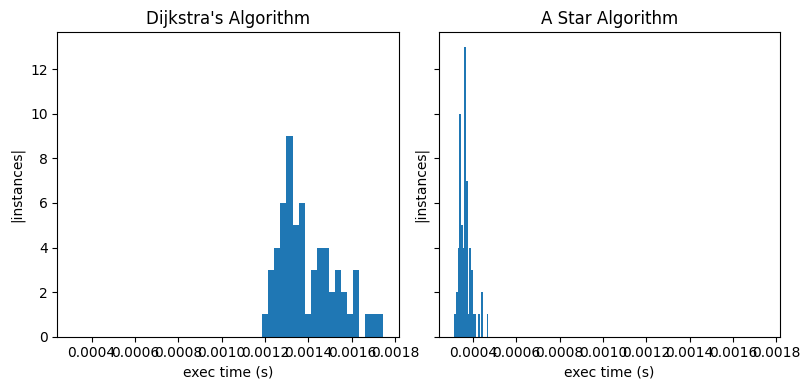

In [13]:
fig, axes = plt.subplots(1,2, sharex = True, sharey= True)
draw_hist(dijkstra_vals, "Dijkstra's Algorithm", axes[0]) 
draw_hist(a_star_vals, "A Star Algorithm", axes[1]) 
fig.set_size_inches(8,4)
fig.tight_layout()
fig.savefig('outputs/histogram_On2.pdf')

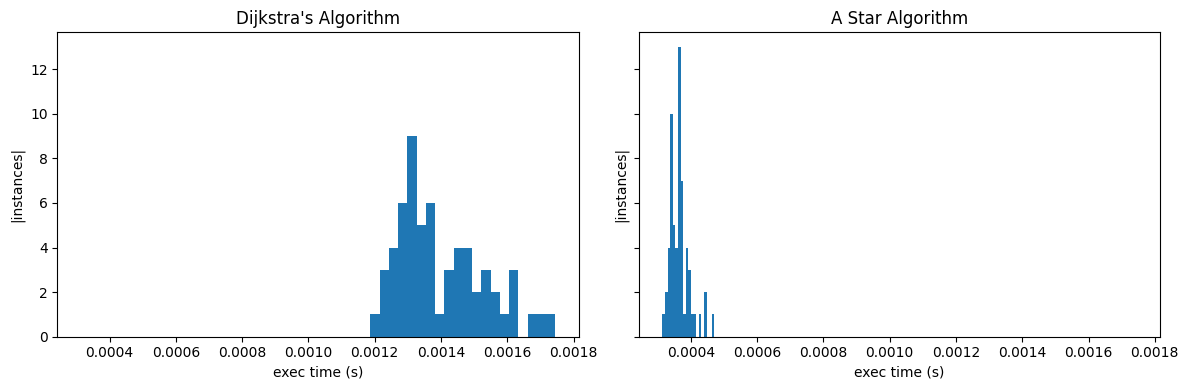

In [14]:
fig, axes = plt.subplots(1,2, sharex = True, sharey= True)
draw_hist(dijkstra_vals, "Dijkstra's Algorithm", axes[0]) 
draw_hist(a_star_vals, "A Star Algorithm", axes[1]) 
fig.set_size_inches(12,4)
fig.tight_layout()
fig.savefig('outputs/histogram_Onlogn.pdf')

In [15]:
from ConnectedIslands import ConnectedIslands

connectedIslands = ConnectedIslands(graph)
print(connectedIslands)

86 connected components
0: 0 43 57 58 153 159 168 203 252 
1: 1 2 5 9 11 12 16 22 25 26 37 40 41 49 67 68 71 72 73 75 82 85 87 89 103 107 114 126 127 129 130 132 136 137 140 141 142 145 146 163 166 167 171 172 181 185 194 200 205 217 219 224 227 230 240 244 246 251 291 
2: 3 21 24 29 30 36 50 55 102 116 135 143 150 175 188 196 199 207 213 222 243 250 258 261 272 292 300 301 
3: 4 220 221 
4: 6 
5: 7 284 
6: 8 34 78 104 109 
7: 10 48 225 226 
8: 13 236 
9: 14 42 74 86 91 187 
10: 15 84 92 128 131 182 190 198 211 249 259 
11: 17 18 51 52 80 133 174 177 189 191 216 237 255 293 
12: 19 53 54 
13: 20 35 39 120 149 231 
14: 23 195 228 241 
15: 27 111 112 164 
16: 28 
17: 31 83 
18: 32 
19: 33 47 
20: 38 212 
21: 44 45 117 165 214 270 
22: 46 
23: 56 151 
24: 59 
25: 60 97 160 173 183 204 257 
26: 61 108 197 262 
27: 62 105 
28: 63 
29: 64 
30: 65 
31: 66 
32: 69 
33: 70 110 234 235 
34: 76 144 254 268 281 
35: 77 123 218 223 256 
36: 79 169 178 253 
37: 81 152 184 242 
38: 88 170 
39: 90 
40

In [16]:
from Patrol import getPatrolPath
stations = random.sample([graph.getNodeData()[x]['id'] for x in graph.getNodeIds()], 10)
print(stations)
result = getPatrolPath(graph, stations)
print(result)

['14', '42', '158', '231', '37', '9', '207', '147', '245', '238']
[14, 9, 207, 147, 231, 245, 42, 238, 37, 158]


S - Single Responsibility
- Each class is doing its thing. Patrol only get the patrolling path and Dijkastra onlt implement one version of the shortest path algorithm
  
O - Open/Closed
- Developers can add new strategies without touching the umderline structure of the client code.
  
L - Liskov Substitution
- ShortestPath exibit behaviour from its parent
  
I - Interface Segregation
- All interfaces are seperated due to their own api to use
  
D - Dependecy Inversion
- Adding more strategies into the system doesn't change the code of the ShortestPathStrategy Interface

From benchmark code, We discorved that the performance of finding all connected island of the stations is dependent on the total number of stations and how the stations are categorized by zones. This is due to it effecting the number of DFS calls.

From benchmark code, we discovered TSP performance is highly dependents on the size of input nodes. Since we need to run shortest path on every targeted Nodes and the permutations of them, the algorithms run in factorial time. 

## Self Reflection (paiw/ Willie Pai)
**1. Have you done a similar kind of work in the past?**
  - Although I have had tons of experience developing programs with Python, I have not implemented any extensive algorithms from scratch. SFWRENG 2C03 has taught me the fundamentals of software algorithms, but it did not challenge me to implement these algorithms into real-world application, as this lab encourages me to do. I am indeed familiar with class structure in Python, as well as implementing abstract classes and using the Typing library to type variables.

**2. How do you feel about this piece of work? What parts do you particularly like? Dislike? Why?**
  - This lab definitely challenged me to think far and beyond the regular coding challenges that I attempt, as I had to think about how to incorporate a complex algorithm into an entire subway network. This forces me to make modifications to the algorithm to accomodate things like line changes and subway zones, which I enjoyed having to think about. Although I was very familiar with using Git version control, I disliked how there was lack of instructions to utilize GitLab to its full potential, which would have been very difficult for less-experienced programmers to figure out for the first time.

**3. What is the one thing you particularly want people to notice about your work?**
 - I was able to successfully implement Dijkstra's algorithm to acommodate the minization of line changes when the same amount of travel time was found for two different paths. I achieved this by modifying the relax() function of Dijkstra's to compare the number of total line changes that a subway rider would have to make to reach a certain station from a starting location. Similar to the distTo attribute, it would store the total number of line changes, and make comparisons to alternative paths, relaxing an edge based on both distTo and lineChangesTo.

**4. What would you change if you had the chance to do this project again?**
 - If I did this project again, I would have appreciated more lectures or tutorials that would help teach us use all these new tools and libraries that some of us have never experienced before. Although there was lecture material to refer to, it was still difficult to understand exactly what the code was doing, and how we could implement our own version of it to fit with our lab.

## Self Reflection (luongn4/ Nathan Luong)

1. **Have you done a similar kind of work in the past?**
  - I have created a library (in C++) before in the past but it was no where near the scale and complexity of this assignment. Thinking back, using git and gitlab to keep track of the versioning of work is crutial since all history are visible and reverseable. This assignment has taught me alot on how to colaborate with team member on a complicated project using git.
  - None of my project from the past had detailed documentations as this one. Documentation along the way helps with clarifying complicated integrations of simple classes. UML is a good way to visualize such integration. 
2. **How do you fell about this piece of work? What parts do you particularly like? Dislike? Why?**
  - Some OOP principle makes the code harder to implement. For example: The usage of Factory Pattern to map a string to a strategy. This could be simplify to an enum which maps a type to a strategy. However, the idea still works when abstracting away the class initialization from the user.
  - I particularly like the benchmarking and testing aspect of the lab. Based on alot of my work in the past, the code returned the right output but I never take into consideration of its run time based on the size of the input. Having the benchmark quantify how good a piece of code is in relation to some baseline.
3. **What is the one thing you particularly want people to notice about your work?**
  - My work is easy to read and easy to pick up. For hard algorithms, I tend to add comments on every lines to explain what the algorithms is doing. I also use readable naming convention to avoid confusion. Our folder structure is also very intuitive to understand since all relevent files are group into a folder to seperate the functionality concern.
4. **What would you change if you had the chance to do this project again?**
 - I would walk into this project with alot more preparation. Knowing some advance python methods would help along the way (permurtations, magic methods).
 - Merge conflicts has been a big problem for Willie and I when we trying to combine our work together. Merging code on a more regular basis would makes solving more easily due to less code being processed.
 - Improving my knowledge on how to comunicate outside of code would also bring cohesion to our communication workflow.